# Assignment 1

Obtain the 200 top-ranking universities in www.topuniversities.com (ranking 2018). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the details page. Store the resulting dataset in a pandas DataFrame. 

By aggregating data in following ways:
* by country
* by region

answer which are the best universities in terms of: 

* ratio between faculty members and students
* ratio of international students

In [1]:
# Imports
import requests
import pandas as pd
import seaborn as sns
%matplotlib inline
from bs4 import BeautifulSoup as bs

In [2]:
# Constants
TOTAL_STAFF_COUNT = 'total_staff_count'
INTERNATIONAL_STAFF_COUNT = 'international_staff_count'
TOTAL_STUDENT_COUNT = 'total_student_count'
INTERNATIONAL_STUDENT_COUNT = 'international_student_count'

# URLs
# Top Universities
TOP_UNIVERSITIES_BASE_URL = 'https://www.topuniversities.com'
TOP_UNIVERSITIES_RANKNING_URL = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1507982846110'
# Times Higher Education
TIMES_HIGHER_EDUCATION_BASE_URL = 'https://www.timeshighereducation.com'
TIMES_HIGHER_EDUCATION_RANKING_URL = 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'

In [5]:
def form_region_dictionary(items, country_key, region_key):
    dictionary = {}
    for item in items:
        # If region is present, update it's contents if needed
        if (item[region_key] in dictionary) and (item[country_key] not in dictionary[item[region_key]]):
            dictionary[item[region_key]].append(item[country_key])
        # If region is not present, create it and put first item
        elif item[region_key] not in dictionary:
            dictionary[item[region_key]] = [item[country_key]]
    return dictionary

def add_region(item, country_key, region_dictionary, default_value='Unknown'):
    result = item.copy()
    result['region'] = default_value
    
    for region, countries in region_dictionary.items():
        if result[country_key] in countries:
            result['region'] = region
            break
    
    return result

def percentage_from_string(word):
    perc = word.strip()
    if perc[-1:] == '%':
        perc = perc[:-1]
    return float(perc) / 100

def int_from_string(word):
    return int("".join(i for i in list(word.strip()) if i.isdigit()))

def float_from_string(word):
    return float("".join(i for i in list(word.strip()) if i.isdigit() or i=='.'))
    
# Helper methods for 'Top Universities'
def tu_parse_ranking(json):
    return list(map(lambda wrapper: { 
            'country' : wrapper['country'],
            'name' : wrapper['title'], 
            'rank' : wrapper['rank_display'], 
            'region' : wrapper['region'],
            'url' : wrapper['url']
        }, json))

def tu_staff_and_students(university):    
    UNI_URL = TOP_UNIVERSITIES_BASE_URL + university['url']
    r = requests.get(UNI_URL)
    
    soup = bs(r.text, 'html.parser')
    result = university.copy()
    
    # Total faculty staff count
    total_staff_wrapper = soup.find('div', class_='total faculty')
    total_staff_count = 0
    
    if total_staff_wrapper:
        total_staff_count = int_from_string(total_staff_wrapper.find('div', class_='number').text)
    
    result[TOTAL_STAFF_COUNT] = total_staff_count
    
    # International faculty staff count
    international_staff_wrapper = soup.find('div', class_='inter faculty')
    international_staff_count = 0
    
    if international_staff_wrapper:
        international_staff_count = int_from_string(international_staff_wrapper.find('div', class_='number').text)

    result[INTERNATIONAL_STAFF_COUNT] = international_staff_count
    
    # Total students count
    total_student_wrapper = soup.find('div', class_='total student')
    total_student_count = 0
    
    if total_student_wrapper:
        total_student_count = int_from_string(total_student_wrapper.find('div', class_='number').text)
    
    result[TOTAL_STUDENT_COUNT] = total_student_count
    
    # International students count
    international_student_wrapper = soup.find('div', class_='total inter')
    international_student_count = 0
    
    if international_student_wrapper:
        international_student_count = int_from_string(international_student_wrapper.find('div', class_='number').text)
    
    result[INTERNATIONAL_STUDENT_COUNT] = international_student_count
    
    return result

# Helper methods for 'Times Higher Education'
def the_parse_ranking(json):
    return list(map(lambda wrapper: {
            'country' : wrapper['location'],
            'name' : wrapper['name'],
            'rank' : wrapper['rank'],
            'url' : wrapper['url']
        }, json))

def the_staff_and_students(university):
    UNI_URL = TIMES_HIGHER_EDUCATION_BASE_URL + university['url']
    r = requests.get(UNI_URL)

    soup = bs(r.text, 'html.parser')
    result = university.copy()

    pane = soup.find('div', class_='panel-pane pane-data-stats')
    elements = pane.find_all('li')
    
    international_student_perc = None
    staff_to_student_ratio = None
    total_student_count = None
    
    for element in elements:
        # International student percentage        
        if element.find('div', class_='keystats pc_intl_students') != None:
            international_student_perc_text = element.find('div', class_='value').text
            international_student_perc = percentage_from_string(international_student_perc_text)
        # Total faculty staff ratio
        elif element.find('div', class_='keystats student_staff_ratio') != None:
            staff_to_student_ratio_text = element.find('div', class_='value').text
            staff_to_student_ratio = float_from_string(staff_to_student_ratio_text)
        # Total student count
        elif element.find('div', class_='keystats number_students') != None:
            total_student_count_text = element.find('div', class_='value').text
            total_student_count = int_from_string(total_student_count_text)
    
    result[TOTAL_STAFF_COUNT] = int(total_student_count / staff_to_student_ratio)
    
    # There is no data avilable on international staff count
    result[INTERNATIONAL_STAFF_COUNT] = 0
    
    result[TOTAL_STUDENT_COUNT] = total_student_count
    result[INTERNATIONAL_STUDENT_COUNT] = int(total_student_count * international_student_perc)
        
    return result

#### Retrieving data from 'TopUniversities' ranking site



In [9]:
r = requests.get(TOP_UNIVERSITIES_RANKNING_URL)
response_json = r.json()['data']

universities = tu_parse_ranking(response_json[:100])
universities = list(map(tu_staff_and_students, universities))

# Forming 'Top Universities' data frame
tu_df = pd.DataFrame.from_dict(universities)

#### Forming region dictionary

In the next part of the exercise we will retrieve data from 'Times Higher Education' university ranking website which does not have region information coupled with inofrmation about the universities. We can solve this problem by forming 'region dictionary' whose keys will be regions introduced in 'Top Universities' data frame, and whose values will be countries associated with said regions and which were also introduced in 'Top Universities' data frame.

In [10]:
region_dictionary = form_region_dictionary(response_json, 'country', 'region')
region_dictionary

{'Africa': ['South Africa', 'Egypt', 'Uganda', 'Morocco', 'Ghana', 'Kenya'],
 'Asia': ['Singapore',
  'China',
  'Hong Kong',
  'Japan',
  'South Korea',
  'Taiwan',
  'Malaysia',
  'Israel',
  'India',
  'Saudi Arabia',
  'Lebanon',
  'Kazakhstan',
  'Thailand',
  'Indonesia',
  'Brunei',
  'Qatar',
  'Philippines',
  'United Arab Emirates',
  'Bahrain',
  'Turkey',
  'Pakistan',
  'Oman',
  'Iran, Islamic Republic of',
  'Iraq',
  'Macao S.A.R., China',
  'Jordan',
  'Kuwait',
  'Azerbaijan',
  'Bangladesh',
  'Sri Lanka',
  'Palestinian Territory, Occupied'],
 'Europe': ['United Kingdom',
  'Switzerland',
  'France',
  'Netherlands',
  'Germany',
  'Belgium',
  'Denmark',
  'Sweden',
  'Ireland',
  'Russia',
  'Finland',
  'Norway',
  'Austria',
  'Spain',
  'Italy',
  'Portugal',
  'Czech Republic',
  'Estonia',
  'Belarus',
  'Greece',
  'Ukraine',
  'Lithuania',
  'Poland',
  'Hungary',
  'Croatia',
  'Latvia',
  'Slovenia',
  'Slovakia',
  'Bulgaria',
  'Romania',
  'Serbia'],
 

#### Retrieving data from 'Times Higher Education' ranking site



In [11]:
r = requests.get(TIMES_HIGHER_EDUCATION_RANKING_URL)
response_json = r.json()['data']

universities = the_parse_ranking(response_json[:200])
universities = list(map(lambda u: add_region(u, 'country', region_dictionary), universities))
universities = list(map(the_staff_and_students, universities))

# Forming 'Times Higher Education' data frame
the_df = pd.DataFrame.from_dict(universities)

#### Adjusting ranks in data frames

Dataframes which we obtained from both ranking sites contain ranks which are not unique to every univeristy. Cases exist where serveral universities share the same rank. We will adjust this and make rank unique to each university in each dataframe by utilizing original order in which univerities appeared on ladders.

In [12]:
tu_df['rank'] = range(1, len(tu_df['rank']) + 1)
the_df['rank'] = range(1, len(the_df['rank']) + 1)

tu_df.head()
the_df.head()

,country,international_staff_count,international_student_count,name,rank,region,total_staff_count,total_student_count,url
0,United Kingdom,0,7755,University of Oxford,1,Europe,1822,20409,/world-university-rankings/university-oxford
1,United Kingdom,0,6436,University of Cambridge,2,Europe,1687,18389,/world-university-rankings/university-cambridge
2,United States,0,596,California Institute of Technology,3,North America,339,2209,/world-university-rankings/california-institut...
3,United States,0,3485,Stanford University,4,North America,2112,15845,/world-university-rankings/stanford-university
4,United States,0,3800,Massachusetts Institute of Technology,5,North America,1284,11177,/world-university-rankings/massachusetts-insti...


In [30]:
# Read saved dataset to avoid recrawling both entire sites
the_df = pd.read_pickle("the_dataset")
tu_df = pd.read_pickle("tu_dataset")

FileNotFoundError: [Errno 2] No such file or directory: 'the_dataset'

Matching entries by name
Let us look at the universities that are present in both data sets. Some are present in both rankings, and some are unique to either ranking. We should make sure that each university only occurs once in each dataset to avoid Problems when matching the two sets. 

In [31]:
def duplicate_list(universities):
    """
    Outputs a list of all duplicate entries in provided list
    """
    counts = {}
    for university in universities:
        if university in counts:
            counts[university] += 1
        else:
            counts[university] = 1
    return [k for k, v in counts.items() if v  > 1]

# Show duplicate universities by name
the_duplicates = the_df[the_df['name'].isin(create_count_dict(the_df['name']))]
if the_duplicates.shape[0] > 0:
    ICD.display(the_duplicates)
else:
    print("No duplicates for the_df")
tu_duplicates = tu_df[tu_df['name'].isin(create_count_dict(tu_df['name']))]
if tu_duplicates.shape[0] > 0:
    ICD.display(tu_duplicates)
else:
    print("No duplicates for tu_df")


NameError: name 'create_count_dict' is not defined

In [32]:
# University names for both rankings
the_names = set(zip(the_df.name, the_df.region))
assert len(the_names) == the_df.shape[0], \
    "# of university names ({}) does not match # of entries ({})".format(len(the_names), the_df.shape[0])
tu_names = set(zip(tu_df.name, tu_df.region))
assert len(tu_names) == tu_df.shape[0], \
    "# of university names ({}) does not match # of entries ({})".format(len(tu_names), tu_df.shape[0])

# Universities present in both data sets
in_both = the_names.intersection(tu_names)
print("Number of universities in both rankings: {}".format(len(in_both)))

# Universities only present in the_names
only_in_the = the_names.difference(tu_names)
print("Number of universities only in the_names: {}".format(len(only_in_the)))

# Universities only present in tu_names
only_in_tu = tu_names.difference(the_names)
print("Number of universities only in tu_names: {}".format(len(only_in_tu)))

Number of universities in both rankings: 53
Number of universities only in the_names: 147
Number of universities only in tu_names: 47


In [33]:
import difflib

def find_matches(word, words):
    return difflib.get_close_matches(word, words, n=3, cutoff=0.6)

for word in only_in_the:
    matches = find_matches(word, only_in_tu)
    if matches:
        print(matches)

In [37]:
merged_df = pd.merge(the_df, tu_df, how='inner', on=['name', 'region'], suffixes=('_the', '_tu'))
merged_df

,country_the,international_staff_count_the,international_student_count_the,name,rank_the,region,total_staff_count_the,total_student_count_the,url_the,total_staff_student_ratio_the,country_tu,international_staff_count_tu,international_student_count_tu,rank_tu,total_staff_count_tu,total_student_count_tu,url_tu,international_staff_student_ratio,total_staff_student_ratio_tu
0,United Kingdom,0,7755,University of Oxford,1,Europe,1822,20409,/world-university-rankings/university-oxford,11.201427,United Kingdom,2964,7353,6,6750,19720,/universities/university-oxford,2.480769,2.921481
1,United Kingdom,0,6436,University of Cambridge,2,Europe,1687,18389,/world-university-rankings/university-cambridge,10.900415,United Kingdom,2278,6699,5,5490,18770,/universities/university-cambridge,2.940737,3.418944
2,United States,0,3485,Stanford University,4,North America,2112,15845,/world-university-rankings/stanford-university,7.502367,United States,2042,3611,2,4285,15878,/universities/stanford-university,1.768364,3.705484
3,United States,0,5284,Harvard University,6,North America,2283,20326,/world-university-rankings/harvard-university,8.903198,United States,1311,5266,3,4350,22429,/universities/harvard-university,4.016781,5.156092
4,United States,0,1909,Princeton University,7,North America,958,7955,/world-university-rankings/princeton-university,8.303758,United States,246,1793,13,1007,8069,/universities/princeton-university,7.288618,8.012910
5,United Kingdom,0,8721,Imperial College London,8,Europe,1390,15857,/world-university-rankings/imperial-college-lo...,11.407914,United Kingdom,2071,8746,8,3930,16090,/universities/imperial-college-london,4.223081,4.094148
6,United States,0,3381,University of Chicago,9,North America,2181,13525,/world-university-rankings/university-chicago,6.201284,United States,635,3379,9,2449,13557,/universities/university-chicago,5.321260,5.535729
7,United States,0,4072,University of Pennsylvania,11,North America,3132,20361,/world-university-rankings/university-pennsylv...,6.500958,United States,1383,4250,19,5499,20639,/universities/university-pennsylvania,3.073030,3.753228
8,United States,0,2552,Yale University,12,North America,2826,12155,/world-university-rankings/yale-university,4.301132,United States,1708,2469,16,4940,12402,/universities/yale-university,1.445550,2.510526
9,United States,0,3719,Johns Hopkins University,13,North America,3604,15498,/world-university-rankings/johns-hopkins-unive...,4.300222,United States,1061,4105,17,4462,16146,/universities/johns-hopkins-university,3.868992,3.618557


__Assignement 4__ 
Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

In [38]:
#idea: try to find why the two datasets have different values and see if there is bias, how to do that?
#create a new df where we consider only the differences between the corresponding variables and see if they are correlated
#or if there is bias between the two data frame.
#NB to do a good work we need merged data
diff_df=pd.DataFrame()
diff_df['total_student_count']=merged_df.total_student_count_the-merged_df.total_student_count_tu
diff_df['total_staff_count']=merged_df.total_staff_count_the-merged_df.total_staff_count_tu
diff_df['international_student_count']=merged_df.international_student_count_the-merged_df.international_student_count_tu

diff_df.describe()

,total_student_count,total_staff_count,international_student_count
total_student_count,1.000000,-0.104816,0.351312
total_staff_count,-0.104816,1.000000,0.244789
international_student_count,0.351312,0.244789,1.000000


In [40]:
diff_df.corr()
#I don't find neither correlation neither bias...maybe with all the dataset we'll have more interesting results
#to discuss and see tomorrow

,total_student_count,total_staff_count,international_student_count
total_student_count,1.000000,-0.104816,0.351312
total_staff_count,-0.104816,1.000000,0.244789
international_student_count,0.351312,0.244789,1.000000


__Manipulating data__
Before starting our analysis, we decided to add to our dataset two new informations, the former is the ratio between the number of international student and the total international staff count of each university snd the latter is the ratio between the total number of students and the total staff count.
The first is computed only for the tu_df dataset because in the_df the data regarding international staff count is missing.
Moreover we decided to discrard the column international_staff_count from the the_df dataframe, because it would be meaningless compute correlation with this attribute, and to trasform the attribute 'region' in a numerical one, in order to try to find a correlation with the other variables.

In [19]:
#adding data
tu_df['international_staff_student_ratio']=tu_df.international_student_count/tu_df.international_staff_count
tu_df['total_staff_student_ratio']=tu_df.total_student_count/tu_df.total_staff_count
the_df['total_staff_student_ratio']=the_df.total_student_count/the_df.total_staff_count

We started calculating the correlation between the numerical variable of our datasets. We expect to see that:
-the number of student is positively correlated with the number of staff and with the number of international student
-the number of international student is positively correlated with the number international staff count
-the higher is the position in the ranking, the bigger is the number of international student
-the higher is the position in the ranking, the bigger is the number of student
-the higher is the position in the ranking, the bigger are the ratio that we computed before
-there would be no correlation between rank and region(if there was the rank would be bias) 

In [20]:
#calculate correlaion for tu_df
tur_df=tu_df.copy()
tur_df['region']=tur_df.region.replace({'Europe': 0, 'North America': 1, 'Asia': 2, 'Oceania':3, 'Latin America':4, 'Africa':5})
tur_df.corr()

,international_staff_count,international_student_count,rank,region,total_staff_count,total_student_count,international_staff_student_ratio,total_staff_student_ratio
international_staff_count,1.000000,0.631686,-0.362822,0.046439,0.663947,0.448468,-0.339763,-0.247369
international_student_count,0.631686,1.000000,-0.073388,0.213788,0.567255,0.763959,0.123404,0.292622
rank,-0.362822,-0.073388,1.000000,0.001236,-0.136190,0.142596,0.245540,0.377728
region,0.046439,0.213788,0.001236,1.000000,0.123046,0.308985,0.016002,0.193616
total_staff_count,0.663947,0.567255,-0.136190,0.123046,1.000000,0.737345,-0.122746,-0.284150
total_student_count,0.448468,0.763959,0.142596,0.308985,0.737345,1.000000,0.215140,0.393389
international_staff_student_ratio,-0.339763,0.123404,0.245540,0.016002,-0.122746,0.215140,1.000000,0.597344
total_staff_student_ratio,-0.247369,0.292622,0.377728,0.193616,-0.284150,0.393389,0.597344,1.000000


In [23]:
#calculate correlaion for the_df
ther_df=the_df.copy()
ther_df['region']=ther_df.region.replace({'Europe': 0, 'North America': 1, 'Asia': 2, 'Oceania':3, 'Unknown':4, 'Africa':5})
ther_df=ther_df.drop(['international_staff_count'], axis=1)
ther_df.corr()

,international_student_count,rank,region,total_staff_count,total_student_count,total_staff_student_ratio
international_student_count,1.000000,-0.328642,0.141653,0.275584,0.578362,0.137570
rank,-0.328642,1.000000,-0.080989,-0.247216,-0.151142,0.107090
region,0.141653,-0.080989,1.000000,0.227842,0.176329,-0.157005
total_staff_count,0.275584,-0.247216,0.227842,1.000000,0.568346,-0.431892
total_student_count,0.578362,-0.151142,0.176329,0.568346,1.000000,0.256495
total_staff_student_ratio,0.137570,0.107090,-0.157005,-0.431892,0.256495,1.000000


Looking at the results, we notice that the corellation between rank positions and our data is stronger in tu_df then in the_d, from that we can understand that the two website use different model to decide the ranking. However the highest, as regarding the rank, is in the tu dataset( international_staff_count/rank -0.53) and it's weaker then our expectation.



__Data visualization__
In this section we try to find more information about our data using usefull plots, such as pairplots or boxplots.
Pairplots are useful to better understand how much is strong the correlation between all different variables of our datasets. 

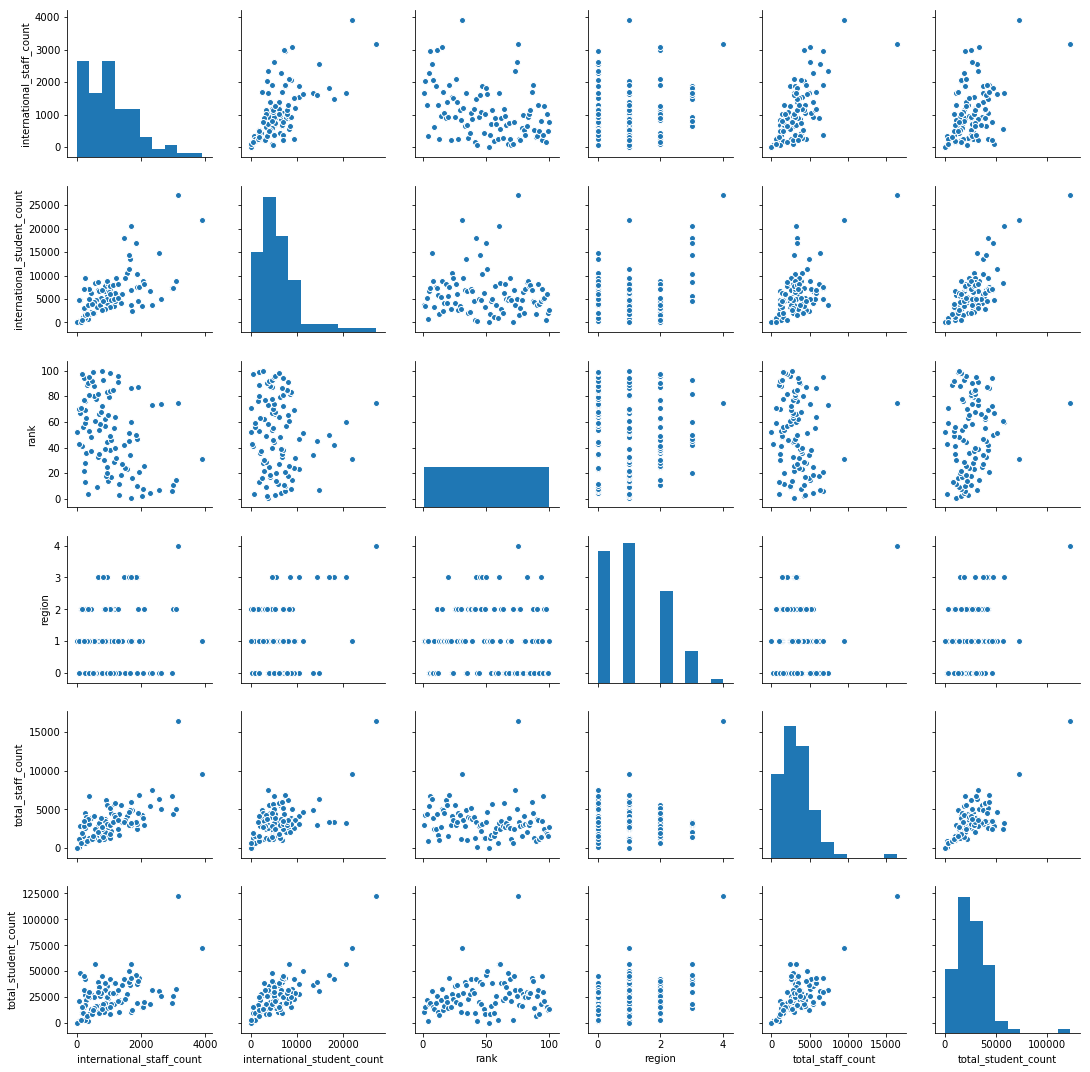

In [21]:
#pairplot tu_df
tur_df=tur_df.drop(['international_staff_student_ratio', 'total_staff_student_ratio'], axis=1)
sns.pairplot(tur_df)


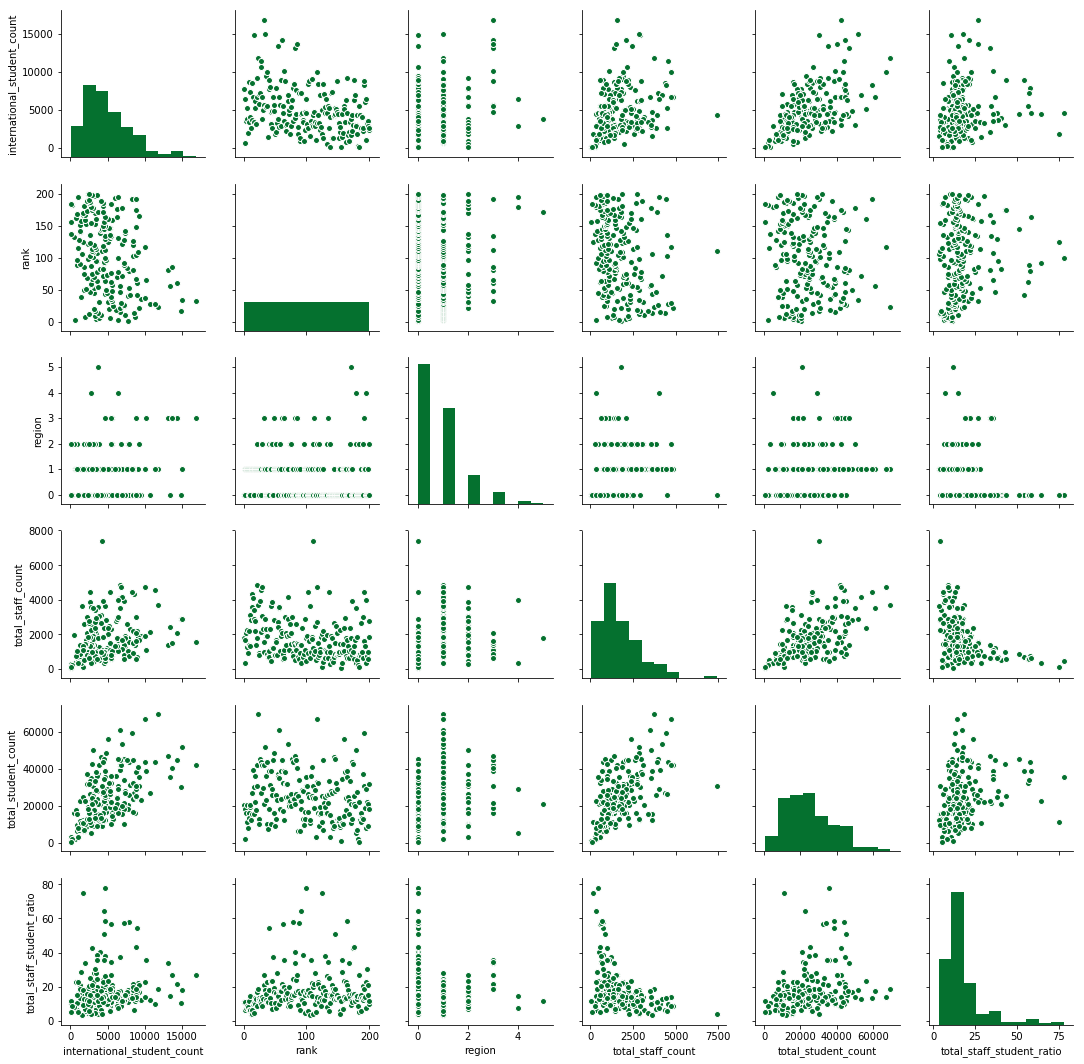

In [24]:
#pair for the_df
with sns.color_palette("BuGn_r"):
    sns.pairplot(ther_df )

In [13]:
##we need to add comment to plots
import matplotlib.pyplot as plt

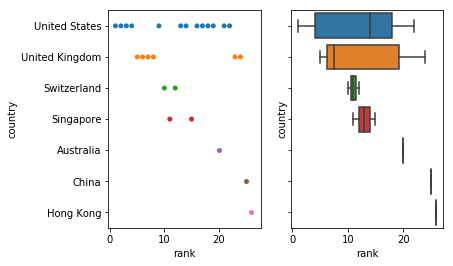

In [17]:
tur_df=tu_df.loc[:25]
f, (ax1, ax2) = plt.subplots(1, 2,sharey=True)
sns.stripplot(x="rank", y="country", data=tur_df, ax=ax1);
sns.boxplot(x="rank", y="country", data=tur_df, ax=ax2);

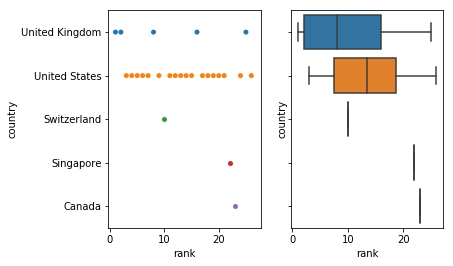

In [18]:
ther_df=the_df.loc[:25]
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
sns.stripplot(x="rank", y="country", data=ther_df, ax=ax1);
sns.boxplot(x="rank", y="country", data=ther_df, ax=ax2);

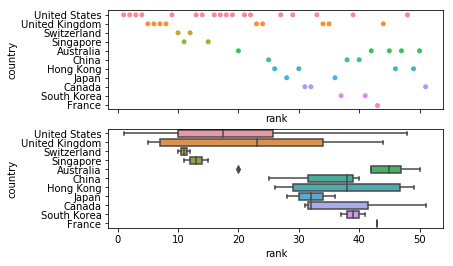

In [28]:
tur_df=tu_df.loc[:50]
f, (ax1, ax2) = plt.subplots(2, 1,sharex=True)
sns.stripplot(x="rank", y="country", data=tur_df, ax=ax1);
sns.boxplot(x="rank", y="country", data=tur_df, ax=ax2);

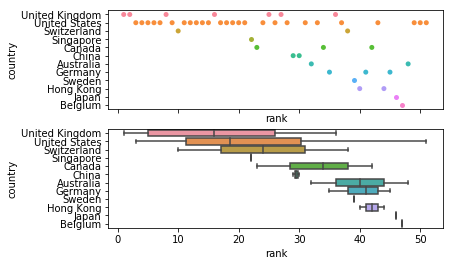

In [29]:
ther_df=the_df.loc[:50]
f, (ax1, ax2) = plt.subplots(2,1, sharex=True)
sns.stripplot(x="rank", y="country", data=ther_df, ax=ax1);
sns.boxplot(x="rank", y="country", data=ther_df, ax=ax2);